In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import albumentations as A

SEED = 1

In [2]:
df = pd.read_csv("94_character_TMNIST.csv", nrows=250000)
#df = df[df['labels'].str.contains('[A-Z]')]
df = df[df['labels'].str.isupper()]
df = df[df['names'].str.contains('sans', case=False)]

In [3]:
print(df.shape)

(8242, 786)


In [4]:
le=LabelEncoder()
df = df.assign(labels = le.fit_transform(df['labels']))

In [5]:
np.shape(df.iloc[:,2:].values)

(8242, 784)

In [82]:
# labels to predict
y = df.labels.values
# normalize features
#X = df.iloc[:,2:].values/255
# binarize image
#X = np.array([1 if val > 127 else 0 for val in df.iloc[:,2:].values])
X = (df.iloc[:,2:].values > 40).astype(int)
X = X.reshape(-1, 28, 28, 1)

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
#X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train).type(torch.LongTensor), torch.from_numpy(y_test).type(torch.LongTensor)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [105]:
print(X_train[0].shape)

(28, 28, 1)


In [56]:
import albumentations as A

# Define the augmentations
transform = A.Compose([
    A.RandomCrop(width=28, height=28)
    #A.Rotate(limit=20, border_mode=0, value=0, p=0.5)
    #A.Affine(scale=(0.8, 1.2), p=0.5)
    #A.Affine(shear=(-20, 20), p=0.5)
    #A.OneOf([
    #    A.Affine(scale=(0.8, 1.2), p=0.5),
    #    A.Affine(shear=(-20, 20), p=0.5),
    #], p=0.5)
])

# Sample an image and apply the augmentation
#image = X_train[0].copy()
#transformed = transform(image=image)
#image_augmented = transformed["image"]

#print(image_augmented.shape)



(28, 28, 1)


In [114]:
mask = np.zeros((28, 28), dtype=np.uint8)
mask[18:24, 18:24] = 1

#from albumentations.augmentations.transforms import MaskDropout

cutout_transform = A.Cutout(num_holes=4, max_h_size=3, max_w_size=3, fill_value=1, p=1)
#dropout = A.augmentations.dropout.mask_dropout.MaskDropout(max_objects=1, image_fill_value=0, mask_fill_value=0, always_apply=False, p=0.5)

#transform = A.Compose([
#    A.augmentations.dropout.mask_dropout.MaskDropout(max_objects=1, image_fill_value=0, mask_fill_value=0, always_apply=False, p=0.5)
#])

# example usage
#img = # your 28x28x1 image
#augmented_img = cutout_transform(image=image_augmented, mask=mask)['image']

X_train_copy = np.copy(X_train)

X_train_augmented = np.zeros_like(X_train)

for i in range(X_train.shape[0]):
    transformed = cutout_transform(image=X_train_copy[i])#, mask=mask)#['image']
    X_train_augmented[i] = transformed["image"]

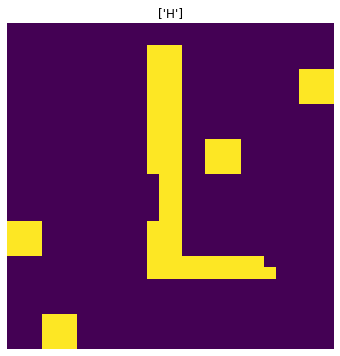

In [134]:
import random

plt.imshow(X_train_augmented[random.randint(0,4000)])
plt.axis("off")
plt.title(str(le.inverse_transform([y[0]])))
plt.show()

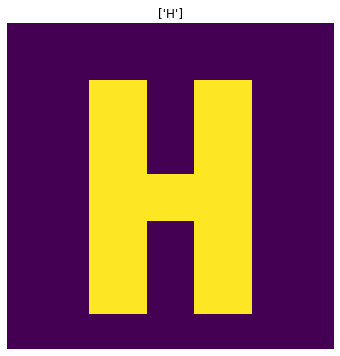

In [25]:
plt.imshow(X[4000])
plt.axis("off")
plt.title(str(le.inverse_transform([y[4000]])))
plt.show()

In [135]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Define the model
model_old = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(26, activation='softmax')
])

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 64)       

In [170]:
#X_train = X_train_augmented
# Normalize the pixel values to be between 0 and 1
#X_train = X_train.astype('float32') / 255.0
#X_test = X_test.astype('float32') / 255.0

# Reshape the images to (28, 28, 1)
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))
print(X_train.shape)

# Convert the labels to one-hot encoded vectors
y_train = tf.one_hot(y_train, 26)
y_test = tf.one_hot(y_test, 26)
print(y_train.shape)

(6593, 28, 28, 1)
(6593, 26)


In [171]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
165/165 [==============================] - 19s 118ms/step - loss: 0.0790 - accuracy: 0.9733 - val_loss: 0.0166 - val_accuracy: 0.9955
Epoch 2/10
165/165 [==============================] - 22s 131ms/step - loss: 0.0559 - accuracy: 0.9808 - val_loss: 0.0229 - val_accuracy: 0.9955
Epoch 3/10
165/165 [==============================] - 20s 124ms/step - loss: 0.0539 - accuracy: 0.9810 - val_loss: 0.0172 - val_accuracy: 0.9932
Epoch 4/10
165/165 [==============================] - 19s 116ms/step - loss: 0.0602 - accuracy: 0.9784 - val_loss: 0.0198 - val_accuracy: 0.9955
Epoch 5/10
165/165 [==============================] - 21s 127ms/step - loss: 0.0607 - accuracy: 0.9824 - val_loss: 0.0205 - val_accuracy: 0.9962
Epoch 6/10
165/165 [==============================] - 19s 115ms/step - loss: 0.0427 - accuracy: 0.9852 - val_loss: 0.0148 - val_accuracy: 0.9977
Epoch 7/10
165/165 [==============================] - 18s 111ms/step - loss: 0.0383 - accuracy: 0.9856 - val_loss: 0.0125 - val_ac

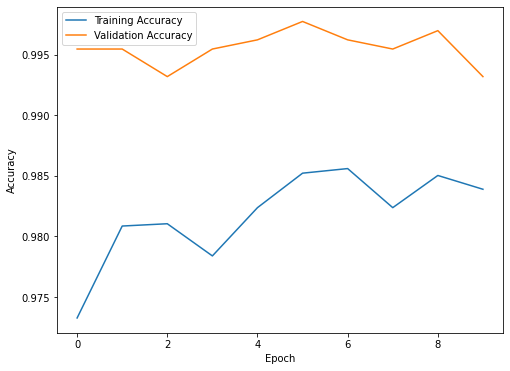

In [172]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [173]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test set loss: {loss:.4f}')
print(f'Test set accuracy: {accuracy:.4f}')

52/52 [==============================] - 2s 32ms/step - loss: 0.0363 - accuracy: 0.9939
Test set loss: 0.0363
Test set accuracy: 0.9939


In [174]:
# Load and preprocess the image
img = cv2.imread('letter_H.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (28, 28))
#binarize
_, binar = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)


img = np.expand_dims(binar, axis=-1)
img = img / 255.0

# Get the predicted class probabilities
probs = model.predict(np.array([img]))

# Get the index of the class with the highest probability
pred_idx = np.argmax(probs)

# Map the index to the corresponding letter label
#label = [k for k, v in train_generator.class_indices.items() if v == pred_idx][0]

print("Predicted letter: ")
print(chr(ord('A')+pred_idx))

1/1 [==============================] - 0s 85ms/step
Predicted letter: 
H


In [50]:
'''
cv2.imshow('Binarized Image', binar)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

: 

feiyang stuff


In [175]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

In [176]:
def find_grid(image, border=True):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    # cv2.imshow('thresh', thresh)
    # RGB_img = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)
    # plt.imshow(RGB_img)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    tiles = []
    max_area = 0
    count = 0

    # find the largest contour: assume to be the edge of the game board
    for c in contours:
        area = cv2.contourArea(c)
        if area > max_area:
            max_area = area
            best_cnt = c
        count += 1

    # find contours within game board again
    mask = np.zeros((gray.shape), np.uint8)
    cv2.drawContours(mask,[best_cnt],0,255,-1)
    cv2.drawContours(mask,[best_cnt],0,0,2)

    out = np.zeros_like(gray)
    out[mask == 255] = gray[mask == 255]
    RGB_img = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)

    # if border:
    #     out = np.zeros_like(gray)
    #     out[mask == 255] = gray[mask == 255]
    #     blur = cv2.GaussianBlur(gray, (7,7), 0)
    #     thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    #     cv2.imshow('thresh', thresh)
    #     RGB_img = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)
    #     plt.imshow(RGB_img)
    #     contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return mask

In [177]:
def perspective_correct(image, mask):
    square = np.zeros((500,500))

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    approx = cv2.approxPolyDP(contours[0], 0.02 * cv2.arcLength(contours[0], True), True)
    if len(approx) == 4:
        # cv2.drawContours(image, [approx], 0, (0, 255, 0), 3)
    # RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(RGB_img)

        # find the corners of the polygon
        center = np.array([0.5 * (approx[:, 0, 0].max() + approx[:, 0, 0].min()),
                        0.5 * (approx[:, 0, 1].max() + approx[:, 0, 1].min())])
        corners = sorted([(approx[i][0][0], approx[i][0][1]) for i in range(len(approx))],
                        key=lambda corner: np.linalg.norm(np.array(corner) - center))

        # order the corners in a clockwise direction starting from the top-left corner
        corners = [corners[i] for i in [1, 0, 2, 3]]

        print(corners)

        # calculate the width and height of the square
        width = np.linalg.norm(np.array(corners[1]) - np.array(corners[0]))
        height = np.linalg.norm(np.array(corners[2]) - np.array(corners[1]))

        # create a transformation matrix to transform the polygon into a square
        src = np.array(corners, dtype=np.float32)
        dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

        h, _ = cv2.findHomography(src, dst)

        # apply the transformation matrix and obtain the corrected square
        square = cv2.warpPerspective(image, h, (int(width), int(height)))
        plt.imshow(square)
        
    return square

In [178]:
def segment_tiles(image):
    rows = 15
    cols = 15

    # Compute the size of each sub-image
    sub_height = image.shape[0] // rows
    sub_width = image.shape[1] // cols

    # Split the image into sub-images
    sub_arrays = []
    for i in range(rows):
        for j in range(cols):
            sub_arrays.append(image[i*sub_height:(i+1)*sub_height, j*sub_width:(j+1)*sub_width])

    fig, axs = plt.subplots(15,15, figsize=(20, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .001, wspace=.001)
    axs = axs.ravel()
    for i, sub_arr in enumerate(sub_arrays):
        axs[i].imshow(sub_arr)
    return sub_arrays


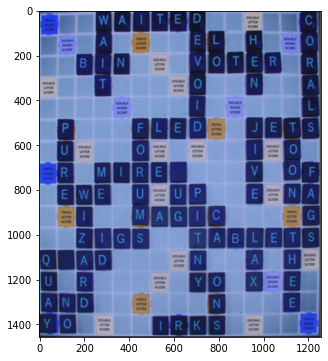

In [179]:
#test_path = 'data/board2.png'
test_path = 'board_edited.png'

test_img = cv2.imread(test_path)
RGB_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

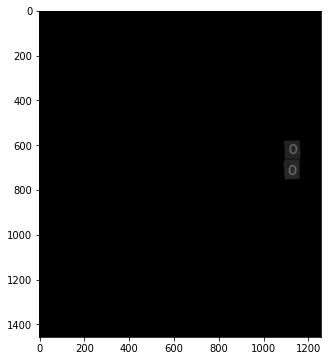

In [163]:
# detects 'data/board.jpeg' inner 25x25 grid
# detects 'data/board5.jpeg' inner 25x25 
# detects 'data/board3.jpeg' inner 25x25 grid
# when board is too contrasty with table detects the board grid
# NOT robust to occlusions

m = find_grid(test_img)

[(1163, 749), (1093, 586), (1096, 756), (1163, 579)]


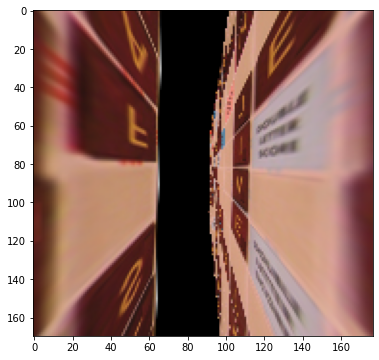

In [164]:
res = perspective_correct(test_img, m)

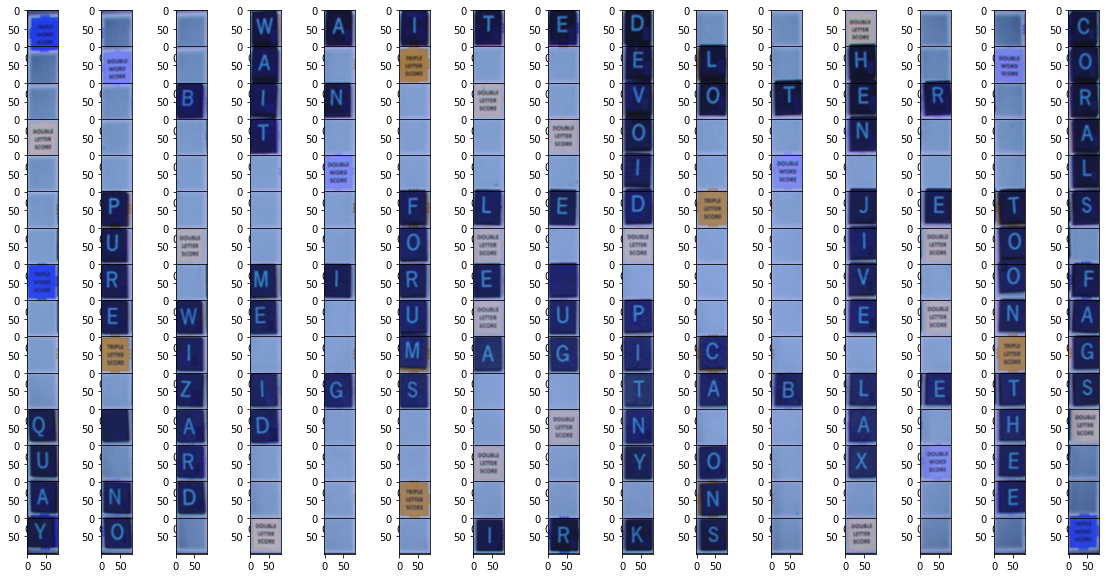

In [166]:
#tiles = segment_tiles(res)
tiles = segment_tiles(RGB_img)

In [ ]:
class UnionFind:
    def __init__(self, size):
        self.rank = np.zeros(size)
        self.parent = np.array([i for i in range(size)])
  
    def find(self, x):
        if self.parent[x] == x:
            return x
        return self.find(self.parent[x])
        
    def union(self, a, b):
        a_label = self.find(a)
        b_label = self.find(b)
        if a_label != b_label:
            self.parent[a_label] = b_label

In [ ]:
def label(binary_img):
    """Label disconnected regions in a binary image.
    
    Args:
    - binary_img: H x W Boolean array representing a binary image where `False`
        indicates background while `True` indicates object regions.
    
    Returns:
    - label_img: H x W int array representing an image with labeled object
        regions where 0 indicates the background while other values represent
        object labels.
    """
    
    # TODO
    label_img = np.copy(binary_img).astype(int)
    label_img = np.pad(label_img, 1) #padding with zeros means it doesn't need to specially deal with border pixels
    h, w = len(label_img), len(label_img[0])
    uf = UnionFind(h*w)

    #loop through all non-padding pixels
    for r, row in enumerate(label_img[1:-1,1:-1]):
        for c, pix in enumerate(row):
            if pix == 1:
                #using 8-connectedness, check neighbors for nonzero values
                if label_img[r-1][c-1] != 0:
                    uf.union((r-1)*w + c-1, r*w + c)
                if label_img[r-1][c] != 0:
                    uf.union((r-1)*w + c, r*w + c)
                if label_img[r-1][c+1] != 0:
                    uf.union((r-1)*w + c+1, r*w + c)
                if row[c-1] != 0:
                    uf.union(r*w + c-1, r*w + c)
                if row[c+1] != 0:
                    uf.union(r*w + c+1, r*w + c)
                if label_img[r+1][c-1] != 0:
                    uf.union((r+1)*w + c-1, r*w + c)
                if label_img[r+1][c] != 0:
                    uf.union((r+1)*w + c, r*w + c)
                if label_img[r+1][c+1] != 0:
                    uf.union((r+1)*w + c+1, r*w + c)
    
    #2nd pass
    labels = np.array([])
    for r, row in enumerate(label_img):
        for c, pix in enumerate(row):
            if pix != 0:
                label = uf.find(r*w + c)
                if label not in labels:
                    labels = np.append(labels, label)
                row[c] = 30+20*np.where(labels==label)[0][0] #assign label of that region (manipulate label # for clearer heatmap)
    
    return label_img[1:-1,1:-1]

label_img = label(binary_img)
plt.matshow(label_img)
plt.show()
obj_count = len(np.unique(label_img)) - 1
print(f"Found {obj_count} objects in image.")

In [ ]:
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in tiles]
imgs = [cv2.resize(img, (28, 28)) for img in imgs]

In [185]:
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in tiles]
for img in imgs:
    
imgs = [cv2.resize(img, (28, 28)) for img in imgs]
#true_labels = ['.','I','K','S','O','R','Y','N','D','N','A','E','.','.','Y','O','X','R','U','E','N','A','D','A','H','-','-','Q','S','T','E','B','A','T','S','G','L','I','Z','G','G','I','A','C','I','.','.','A','U','N','E','P','=','E','W','E','F','V','E','R','-','-','I','M','R','=','I','O','U','S','T','E','J','.','.','D','E','L','F','P','L','I','A','N','R','T','N','B','=','=','=','=','E','I','T','A','=']

#print(imgs)

true_labels = [['', '', '', 'W', 'A', 'I', 'T', 'E', 'D', '', '', '', '', '', 'C'],
              ['', '', '', 'A', '', '', '', '', 'E', 'L', '', 'H', '', '', 'O'],
              ['', '', 'B', 'I', 'N', '', '', '', 'V', 'O', 'T', 'E', 'R', '', 'R'],
              ['', '', '', 'T', '', '', '', '', 'O', '', '', 'N', '', '', 'A'],
              ['', '', '', '', '', '', '', '', 'I', '', '', '', '', '', 'L'],
              ['', 'P', '', '', '', 'F', 'L', 'E', 'D', '', '', 'J', 'E', 'T', 'S'],
              ['', 'U', '', '', '', 'O', '', '', '', '', '', 'I', '', 'O', ''],
              ['', 'R', '', 'M', 'I', 'R', 'E', '', '', '', '', 'V', '', 'O', 'F'],
              ['', 'E', 'W', 'E', '', 'U', '', 'U', 'P', '', '', 'E', '', 'N', 'A'],
              ['', '', 'I', '', '', 'M', 'A', 'G', 'I', 'C', '', '', '', '', 'G'],
              ['', '', 'Z', 'I', 'G', 'S', '', '', 'T', 'A', 'B', 'L', 'E', 'T', 'S'],
              ['Q', '', 'A', 'D', '', '', '', '', 'N', '', '', 'A', '', 'H', ''],
              ['U', '', 'R', '', '', '', '', '', 'Y', 'O', '', 'X', '', 'E', ''],
              ['A', 'N', 'D', '', '', '', '', '', '', 'N', '', '', '', 'E', ''],
              ['Y', 'O', '', '', '', '', 'I', 'R', 'K', 'S', '', '', '', '', '']]

# Define threshold value
thresh_value = 80

with open("output.txt", "w") as f:
    print("", file = f)

# Iterate over list of grayscale images
for i in range(len(imgs)):
    # Apply thresholding to binarize the image
    _, bin_image = cv2.threshold(imgs[i], thresh_value, 1, cv2.THRESH_BINARY)
    kernel = np.ones((2,2), np.uint8)
    eroded = cv2.erode(bin_image, kernel, iterations=1)
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    
    # Replace original image with binarized image in list
    imgs[i] = bin_image

print(np.array(imgs))

#print("greyscale", imgs[2])
with open("output.txt", "w") as f:
    for i in range(len(imgs)):
        print(imgs[i], file=f)
#imgs = np.array([int(np.expand_dims(img, axis=-1) < 127) for img in imgs])
imgs = np.array([np.expand_dims(img, axis=-1) for img in imgs])


# Get the predicted class probabilities for all the images
probs = model.predict(imgs)

# Get the indices of the classes with the highest probability for all the images
pred_indices = np.argmax(probs, axis=1)

#print(pred_indices)
#print(probs[0])
#for i, s in enumerate(probs):
#    print(s[pred_indices[i]])
#print([s[i] for i in pred_indices for s in probs])

# Map the indices to the corresponding letter labels
#labels = [chr(ord('A')+i) for i in pred_indices]
labels = []
for i, idx in enumerate(pred_indices):
    if probs[i][idx] > 0.7:
        labels.append(chr(ord('A')+idx))
    else:
        labels.append('')

print("Predicted letters: ")
for i in range(15):
    print(labels[15*i:15+15*i])

#print(true_labels)
#print(sum((np.array(true_labels)==np.array(labels)))/len(true_labels))


[[[0 0 0 ... 0 0 0]
  [0 1 1 ... 1 1 1]
  [0 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[0 0 0 ... 0 0 0]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[0 0 0 ... 0 0 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 ...

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [0 0 0 ... 0 0 0]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [0 0 0 ... 0 0 0]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [0 0 0 ... 0 0 0]]]
8/8 [==============================] - 0s 16ms/step
Predicted letters: 
['', '', '', 'W', 'W', 'I', 'I', 'Q', 'Y', '', '', '', '', '', 'Q']
['', '', '', 'W', '', '', '', '', 'F', 'E', '', '', '', '', 'Q']
['', '', '', '', '', 

In [161]:
for i in range(225):
    print(labels[i], probs[i][pred_indices[i]])

 0.58679724
I 0.77659816
I 0.77659816
W 0.9991918
A 0.9974342
I 0.8175565
 0.62971216
A 0.78274465
 0.62938505
I 0.77659816
I 0.77659816
 0.12106283
I 0.77659816
I 0.7689589
Q 0.9997309
I 0.77659816
 0.43032488
I 0.77659816
A 0.99725986
I 0.78178334
 0.27478
I 0.77659816
I 0.77659816
 0.29767618
S 0.8316437
I 0.7372245
 0.39664626
I 0.76682496
 0.119484685
Q 0.99064845
I 0.7765982
I 0.7765983
A 0.9769717
L 0.7682809
 0.5944247
I 0.77659816
 0.3307629
I 0.77659816
Y 0.9994665
R 0.9668342
I 0.9773038
F 0.74046266
 0.5080965
I 0.77659816
 0.6677451
 0.63649696
I 0.77659816
I 0.7762514
 0.6725002
I 0.77659816
I 0.77659816
I 0.77659816
 0.41278923
Q 0.8232383
I 0.77659816
I 0.77659816
N 0.8597912
I 0.77659816
I 0.77659816
A 0.99958044
I 0.77659816
I 0.77659816
I 0.7765982
I 0.7765983
 0.21673955
I 0.77659816
I 0.77659816
I 0.77659816
 0.6939011
I 0.77659816
 0.3175425
I 0.7636313
I 0.7648959
I 0.7647046
 0.4764563
I 0.77659816
A 0.873116
I 0.77659816
I 0.77659816
I 0.77659816
 0.17504418
U 

In [ ]:
#albumentations or pytorch transform
#figure out rgb
#random affine transform and rotation and scaling
#add number on the bottom right


In [43]:
img = cv2.resize(img, (28, 28))
img = np.expand_dims(img, axis=-1)
img = img / 255.0

# Get the predicted class probabilities
probs = model.predict(np.array([img]))

# Get the index of the class with the highest probability
pred_idx = np.argmax(probs)

# Map the index to the corresponding letter label
#label = [k for k, v in train_generator.class_indices.items() if v == pred_idx][0]

print("Predicted letter: ")
print(chr(ord('A')+pred_idx))

1/1 [==============================] - 0s 53ms/step
Predicted letter: 
J


trash 

In [127]:
from keras.datasets import mnist
(x_train_m, y_train_m_start), (x_test_m, y_test_m_start) = mnist.load_data()
x_train_m[0].shape
X_train_m = x_train_m.astype('float32') / 255.0
X_test_m = x_test_m.astype('float32') / 255.0

# Reshape the images to (28, 28, 1)
X_train_m = np.reshape(X_train_m, (len(X_train_m), 28, 28, 1))
X_test_m = np.reshape(X_test_m, (len(X_test_m), 28, 28, 1))
print(X_train_m.shape)

# Convert the labels to one-hot encoded vectors
y_train_m = to_categorical(y_train_m_start, 26)
y_test_m = to_categorical(y_test_m_start, 26)
print(y_train_m.shape)

(60000, 28, 28, 1)
(60000, 26)


In [83]:

from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.metrics import roc_auc_score, accuracy_score
'''
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))



'''
model = Sequential()
model.add(Conv2D(32,(4,4),input_shape = (28,28,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(94, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 1600)             

ValueError: in user code:

    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 94) are incompatible


In [81]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test set loss: {loss:.4f}')
print(f'Test set accuracy: {accuracy:.4f}')

52/52 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0352
Test set loss: 0.0000
Test set accuracy: 0.0352


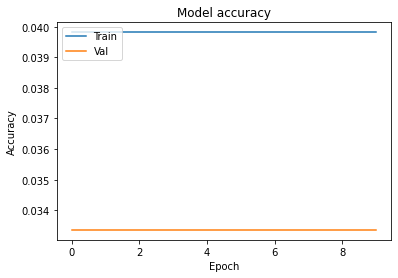

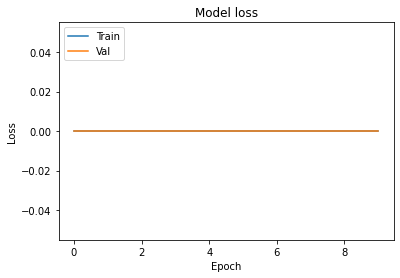

In [82]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

test other